In [2]:
%conda install -c conda-forge netcdf4 libgfortran boto3 numpy matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 22.9.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/studio-lab-user/.conda/envs/default

  added / updated specs:
    - boto3
    - libgfortran
    - matplotlib
    - netcdf4
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alsa-lib-1.2.8             |       h166bdaf_0         578 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    brotli-1.0.9               |       h166bdaf_8          18 KB  conda-forge
    brotli-bin-1.0.9           |       h166bdaf_8          20 KB  conda-forge
    contourpy-1.0.5            |   py39hf939315_1         234 KB  conda-forge
    cryptography-38.0.2        |   py39hd97740a_2         1.6 MB  conda-forge
   

In [3]:
# %% Pirate Weather Example script for SMSL  

import os
import json
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import os
import shutil
import sys
import uuid
from urllib.parse import unquote_plus

from netCDF4 import Dataset
import numpy as np

# Plotting tools
import matplotlib.pyplot as plt

# Date processing
from datetime import datetime, timedelta

#os.system('apt install gfortran')

# Wgrib2 setup
import pywgrib2_s

finished loading libraries
pywgrib2_s v0.0.8 10-19-2020 w. ebisuzaki


In [4]:
# S3 Client Setup
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3 = boto3.resource('s3')


In [5]:
#%% Set download variables
bucket          = 'noaa-hrrr-bdp-pds'
download_path   = '/tmp'
time_in         = '2022-09-16T00:00:00'
product         = 'hrrr'

# Datetime Setup
datetime_RUN        = datetime.strptime(time_in,"%Y-%m-%dT%H:%M:%S")
fDate          = datetime_RUN.strftime("%Y%m%d")
runTime        = "t" + datetime_RUN.strftime("%H") + "z"

# Path Setup
download_path_CK    = download_path + '/' + product + '/' + fDate + '/' + runTime + '/' + 'out_' + product + '_chunked.nc'
download_path_NC_A  = download_path + '/' + product + '_tmp.nc'

if not os.path.exists(download_path + '/' + product):
    os.makedirs(download_path + '/' + product)
if not os.path.exists(download_path + '/' + product + '/' + fDate):
    os.makedirs(download_path + '/' + product + '/' + fDate)
if not os.path.exists(download_path + '/' + product + '/' + fDate + '/' + runTime):
    os.makedirs(download_path + '/' + product + '/' + fDate + '/' + runTime)

In [6]:
# Setup grid transformation parameters 
HRRR_grid1 = 'lambert:262.500000:38.500000:38.500000:38.500000'
HRRR_grid2 = '237.280472:1799:3000.000000'
HRRR_grid3 = '21.138123:1059:3000.000000'


In [7]:
# Download Grib File from AWS Open Data
# Setup file names
grbType   = 'wrfsfc'

# Set the range of forecasts to download
ncFileRange_A = range(1, 7)

for ncFileName in ncFileRange_A:
    download_file_pathA  = download_path + '/hrrrh.f' + str(ncFileName).zfill(3) + '.' + grbType + '.grb'
    download_path_GB_A   = download_path + '/hrrrh.f' + str(ncFileName).zfill(3) + '.' + grbType + '.grb.earth'

    s3_filename = 'hrrr.' + fDate + '/conus/hrrr.' + runTime + '.wrfsfcf' + str(ncFileName).zfill(2) + '.grib2'

    # Download the grib file
    s3_client.download_file(bucket, s3_filename, download_file_pathA)

    #%% Process Downloaded File

    # Set variables to read
    matchString = (":(TMP:2 m above ground|CRAIN:surface|CSNOW:surface|"
                   "CFRZR:surface|PRATE:surface|PRES:surface|CICEP:surface|"
                   "UGRD:10 m above ground:.*hour fcst|"
                   "VGRD:10 m above ground:.*hour fcst|"
                   "VIS:surface|DPT:2 m above ground|TCDC:entire atmosphere|GUST:surface|RH:2 m above ground):")

    # Extract variables and convert winds from grid relative to earth relative
    pywgrib2_s.wgrib2([download_file_pathA, '-new_grid_winds', 'earth', '-new_grid_interpolation', 'neighbor', '-match', matchString, '-new_grid', HRRR_grid1, HRRR_grid2, HRRR_grid3, download_path_GB_A])
    # Add precipitation
    pywgrib2_s.wgrib2([download_file_pathA, '-rewind_init', download_file_pathA, '-new_grid_winds', 'earth', '-new_grid_interpolation', 'neighbor', '-match', 'APCP', '-append','-new_grid', HRRR_grid1, HRRR_grid2, HRRR_grid3, download_path_GB_A, '-quit'])
    pywgrib2_s.close(download_path_GB_A)

    # Add to NetCDF
    pywgrib2_s.wgrib2([download_path_GB_A, '-append', '-netcdf', download_path_NC_A])

    pywgrib2_s.close(download_file_pathA)
    pywgrib2_s.close(download_path_GB_A)

    os.remove(download_file_pathA)
    os.remove(download_path_GB_A)

    print(ncFileName)

5:1127023:d=2022091600:VIS:surface:1 hour fcst:
9:3101625:d=2022091600:GUST:surface:1 hour fcst:
62:37324699:d=2022091600:PRES:surface:1 hour fcst:
71:43782724:d=2022091600:TMP:2 m above ground:1 hour fcst:
74:47636057:d=2022091600:DPT:2 m above ground:1 hour fcst:
75:48801379:d=2022091600:RH:2 m above ground:1 hour fcst:
77:50900530:d=2022091600:UGRD:10 m above ground:1 hour fcst:
78:53282145:d=2022091600:VGRD:10 m above ground:1 hour fcst:
83:59462331:d=2022091600:PRATE:surface:1 hour fcst:
90:59711087:d=2022091600:CSNOW:surface:1 hour fcst:
91:59711574:d=2022091600:CICEP:surface:1 hour fcst:
92:59711866:d=2022091600:CFRZR:surface:1 hour fcst:
93:59712054:d=2022091600:CRAIN:surface:1 hour fcst:
116:79686573:d=2022091600:TCDC:entire atmosphere:1 hour fcst:
84:59514157:d=2022091600:APCP:surface:0-1 hour acc fcst:
1:0:d=2022091600:VIS:surface:1 hour fcst:
2:2381615:d=2022091600:GUST:surface:1 hour fcst:
3:4525087:d=2022091600:PRES:surface:1 hour fcst:
4:7382987:d=2022091600:TMP:2 m abov

In [12]:
# Chunk NetCDF
# Remove Chunk file if exists
if os.path.isfile(download_path_CK):
  os.remove(download_path_CK)
if os.path.isfile(download_path  + '/' + product + '/' + fDate + '/' + runTime + '/' + product + '.done'):
        os.remove(download_path  + '/' + product + '/' + fDate + '/' + runTime + '/' + product + '.done')


In [13]:
# Setup New Datasets
chkA    = Dataset(download_path_CK, "w")
srcA    = Dataset(download_path_NC_A, 'r', format="NETCDF3_CLASSIC")

# Copy global attributes all at once via dictionary
src = srcA
chk = chkA
chk.setncatts(srcA.__dict__)



In [14]:
#%% Copy dimensions for source NetCDF
for name, dimension in src.dimensions.items():
    chk.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))


In [15]:
#%% Copy all file data
# This step puts the NetCDF file into time oriented chuncks, as well as adding compression
for name, variable in src.variables.items():
    if len(variable.dimensions)==3:
        if 'PRATE_surface' in name:
            x = chk.createVariable(name, variable.datatype, variable.dimensions, chunksizes=[30, 10, 10], zlib=True, least_significant_digit=4, complevel=1)
        else:
            x = chk.createVariable(name, variable.datatype, variable.dimensions, chunksizes=[30, 10, 10], zlib=True, least_significant_digit=1, complevel=1)
    else:
        x = chk.createVariable(name, variable.datatype, variable.dimensions)

    chk[name][:] = src[name][:]
    # copy variable attributes all at once via dictionary
    for ncattr in src[name].ncattrs():
        if ncattr != '_FillValue':
            chk[name].setncattr(ncattr, src[name].getncattr(ncattr))

src.close()
chk.close()



/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [16]:
ChunkNCfile = Dataset(download_path_CK, 'r')

# Read Latitude, Longitude, and Times points in file
lats_hrrr = ChunkNCfile['latitude'][:, :]
lons_hrrr = ChunkNCfile['longitude'][:, :]
times_hrrr = ChunkNCfile['time'][:]

# Convert timestamps to datetimes
datetime_hrrr = []
for i in range(0, len(times_hrrr)):
    datetime_hrrr.append(datetime.fromtimestamp(times_hrrr[i]))

# Set desired lat long
Point_Lat = 45.4215
Point_Lon = -75.6972+360

# Find cloest point
abslat = np.abs(lats_hrrr-Point_Lat)
abslon = np.abs(lons_hrrr-Point_Lon)
c = np.maximum(abslon, abslat)
x_hrrr, y_hrrr = np.where(c == np.min(c))

# Exract and print temperature forecast!
vard = ChunkNCfile['TMP_2maboveground'][:, x_hrrr, y_hrrr]

# Convert to degrees Celsius
print(vard-272.15)


[[[11.537506]]

 [[11.162506]]

 [[10.725006]]

 [[11.037506]]

 [[11.600006]]

 [[12.037506]]]


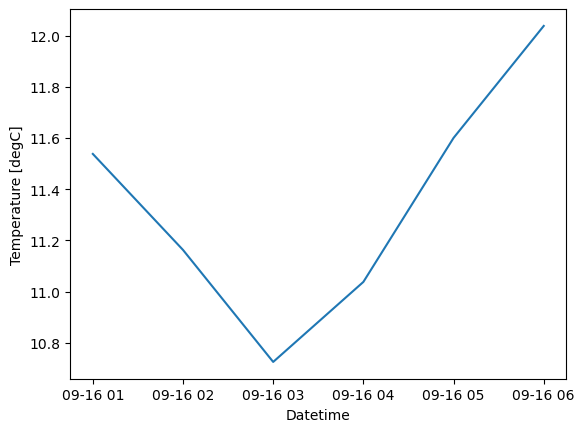

In [17]:
fig = plt.figure()

plt.plot(datetime_hrrr, vard[:, 0, 0]-272.15)
plt.xlabel('Datetime')
plt.ylabel('Temperature [degC]')
plt.show()








0